In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict

import os
import os.path as osp

In [2]:
import re
stream_re = re.compile(r"(\w+)_\w+.npz")

index_file = "./data/Cert_136033-149442_7TeV_Apr21ReReco_Collisions10_JSON_v2.txt"

columns = [
    'run', 'lumiBlock', 'timeHigh', 'timeLow',
    'jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_fX', 'yet_fY', 'yet_fZ',
    'pho_pt', 'pho_eta', 'pho_phi',             'pho_fX', 'pho_fY', 'pho_fZ',
    'muo_pt', 'muo_eta', 'muo_phi', 'muo_mass', 'muo_fX', 'muo_fY', 'muo_fZ',
    'instantLumi'
]

features = [
    'jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_fX', 'yet_fY', 'yet_fZ',
    'pho_pt', 'pho_eta', 'pho_phi',             'pho_fX', 'pho_fY', 'pho_fZ',
    'muo_pt', 'muo_eta', 'muo_phi', 'muo_mass', 'muo_fX', 'muo_fY', 'muo_fZ',
    'instantLumi'
]

In [3]:
def read(path='./data/', target_stream = 'minibias', columns = None):
    df = pd.DataFrame()

    get_stream = lambda item: stream_re.findall(item)[0]
    
    streams_data = list()
    
    for item in [ x for x in os.listdir(path) if x.endswith('.npz') ]:
        stream = get_stream(item)
        if stream != target_stream:
            continue

        print 'Reading', item
        
        npz = np.load(osp.join(path, item))

        assert npz.keys() == ['array']
        
        array = npz['array']
        df = pd.DataFrame(array)
        
        streams_data.append(df)
        npz.close()
    
    df = pd.concat(streams_data)

    if columns is not None:
        df.columns = columns

    df['run'] = df['run'].astype('int64')
    df['lumiBlock'] = df['lumiBlock'].astype('int64')
    df['time'] = df['timeHigh'] * 1.0e+6 + df['timeLow']

    df[features] = df[features].astype('float32')

    del df['timeHigh']
    del df['timeLow']

    return df

In [4]:
data = read(columns=columns)

Reading minibias_pac.npz
Reading minibias_paf.npz
Reading minibias_pab.npz
Reading minibias_paa.npz
Reading minibias_pae.npz
Reading minibias_pad.npz


In [5]:
data.head()

,run,lumiBlock,jet_pt,jet_eta,jet_phi,jet_mass,jet_fX,yet_fY,yet_fZ,pho_pt,...,pho_fZ,muo_pt,muo_eta,muo_phi,muo_mass,muo_fX,muo_fY,muo_fZ,instantLumi,time
0,146807,30,4.624308,0.236238,0.069428,0.31042,0.094528,0.015597,0.102385,0,...,0,0,0,0,0,0,0,0,27.273905,1.285655e+15
1,146807,30,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,27.273905,1.285655e+15
2,146807,30,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,27.273905,1.285655e+15
3,146807,30,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,27.273905,1.285655e+15
4,146807,30,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,27.273905,1.285655e+15


In [6]:
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
features_per_column = len(percentiles) + 6

def extract_features(xs):
    result = np.ndarray(shape=(xs.shape[1], features_per_column),  dtype='float64')

    for i in xrange(xs.shape[1]):
        x = xs[:, i]
        
        result[i, 0] = np.sum(x)
        result[i, 1] = np.mean(x)
        
        result[i, 2] = np.sum(x == 0.0)
        result[i, 3] = np.mean(x == 0.0)
        
        if result[i, 2] < 1.0:
            result[i, 4] = np.std(x)
            result[i, 5] = np.std(x[x != 0.0])
        else:
            result[i, 4] = -1.0
            result[i, 5] = -1.0
        
        result[i, 6:] = np.percentile(x, percentiles) - np.mean(x)
        
        

    return result.ravel()


def group_n_extract(data):
    grouped = data.groupby(by=['run', 'lumiBlock'], sort=False)
    
    run_lumi = list()
    stats = list()
    weights = list()
    
    for i in grouped.groups.keys():
        run, lumi_block = i
        idx = np.array(grouped.groups[i])

        n_events = idx.shape[0]

        lumidata = data.iloc[idx][features].values
        fs = extract_features(lumidata)

        lumi_features = np.zeros(shape=fs.shape[0] + 1, dtype=fs.dtype)
        lumi_features[-1] = n_events
        lumi_features[:-1] = fs

        
        weight = np.mean(data.iloc[idx]['instantLumi'].values)

        run_lumi.append((run, lumi_block))
        stats.append(lumi_features)
        weights.append(weight)
    
    run_lumi = np.array(run_lumi, dtype='int32')
    stats = np.array(stats)
    weights = np.array(weights)

    return run_lumi, weights, stats

In [7]:
idx, ws, X = group_n_extract(data)

In [8]:
print X.shape

(40772, 316)


In [9]:
del data

In [10]:
features_per_column

15

In [11]:
m = X.shape[1]

In [12]:
jet_features = range(7 * features_per_column)
pho_features = range(7 * features_per_column, 13 * features_per_column)
mou_features = range(13 * features_per_column, 20 * features_per_column)

In [13]:
import json

with open(index_file, 'r') as f:
    labels = json.load(f)

In [14]:
y = np.zeros(shape=idx.shape[0], dtype='int32')

for i, (run, lumi_block) in enumerate(idx):
    if str(run) not in labels:
        continue

    run_idxs = labels[str(run)]

    for a, b in run_idxs:
        if a <= lumi_block <= b:
            y[i] = 1
            continue

In [15]:
from sklearn.cross_validation import train_test_split

In [16]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, ws, test_size=0.8, stratify=y, random_state = 333)

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, max_depth=7, n_jobs=-1)

In [31]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
proba_train = clf.predict_proba(X_train)
proba = clf.predict_proba(X_test)

ROC AUC (train) = 0.894


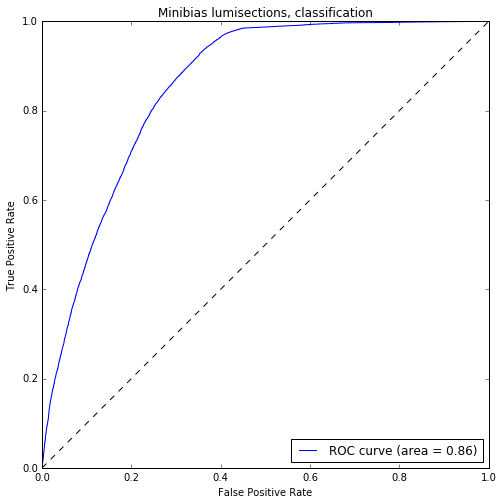

In [33]:
from sklearn.metrics import roc_curve, auc

fpr_train, tpr_train, thr_train = roc_curve(y_train, proba_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

print 'ROC AUC (train) = %.3f' % roc_auc_train


fpr, tpr, thr = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot(fpr_train, tpr_train, '--', label='ROC curve, train (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Minibias lumisections, classification')
plt.legend(loc="lower right")
plt.show()